## 4. Modeling  
This stage aims to build a clustering model that is able to classify the states to an interpretable manner

## Contents  
### 4.1 Importing modules & loading data
### 4.2 Unsupervised clustering  
    a. Data preprocessing  
    b. KMean clustering hyperparameter optimization  
    c. KMean Modeling  

### 4.3 Summary & Conclusion 

### 4.1 Importing modules & loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import plotly.express as px

In [3]:
mass_shooting = pd.read_csv('../data/Clean_data/MassShooting_EDA.csv',index_col='date')

### 4.2 Unsupervised clustering  
#### Clustering states by total_victims?, population, employeed, unemployment_rate, total_licensees, total_gun_deaths, gender, age, sectors, mentor_health_issues features

### a. Data preprocessing

In [4]:
df = mass_shooting.drop(['date.1','fatalities', 'injured','policeman_killed',
  'total_victims_log','employed_at', 'population','state_labor_force','state',
  'total_licensees ','total_children_teen_gun_deaths','year','age_group'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 2009-03-10 to 2018-11-19
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_victims               244 non-null    int64  
 1   age                         244 non-null    int64  
 2   employeed(Y/N)              244 non-null    int64  
 3   mental_health_issues        244 non-null    int64  
 4   gender                      244 non-null    int64  
 5   licensed_business_entities  244 non-null    int64  
 6   total_gun_deaths            244 non-null    int64  
 7   state_population            244 non-null    float64
 8   unemployment_rate           244 non-null    float64
 9   sectors                     244 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 21.0+ KB


In [5]:
# features = df.drop('total_victims',axis=1)
features = df
target = df['total_victims']

In [6]:
# Scale features
features_scaled = StandardScaler().fit_transform(features)
print(features_scaled.shape,len(features.columns))

(244, 10) 10


The cumulative variance of the 7 principal components is 0.94184


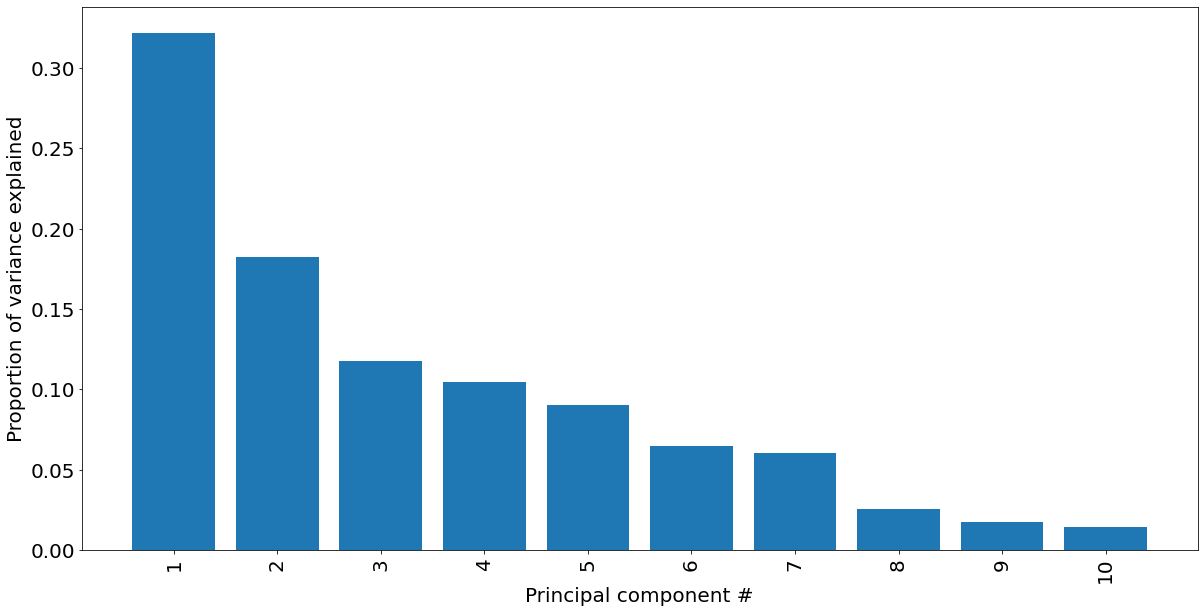

In [7]:
pca = PCA()
# Fit the standardized data to the pca
pca.fit(features_scaled)

# Plot the proportion of variance explained on the y-axis of the bar plot
plt.figure(figsize=(20,10))
plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
plt.xlabel('Principal component #',fontsize=20)
plt.ylabel('Proportion of variance explained',fontsize=20)
plt.xticks(range(1,11), fontsize=20, rotation=90)
plt.yticks(fontsize=20)

# Compute the cumulative proportion of variance explained by the 7 principal components
seven_comp_var_exp = 0
for i in range(pca.n_components_ - 3):
    seven_comp_var_exp += pca.explained_variance_ratio_[i].cumsum()[0]
print("The cumulative variance of the 7 principal components is {}".format(
    np.round(seven_comp_var_exp, 5)))

#### 5 components selection seems work more stably than 7, which might introduce more noise to the result

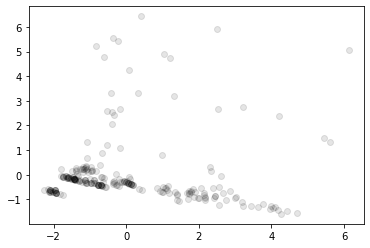

In [8]:
# Transform the scaled features using 5 principal components
pca = PCA(n_components=5)
p_comps = pca.fit_transform(features_scaled)

df_pcomps = pd.DataFrame(p_comps)

# Plot the first two principal components in a scatter plot
plt.scatter(df_pcomps[0],df_pcomps[1],alpha=0.1,color='black')

### b. KMean clustering hyperparameter optimizing

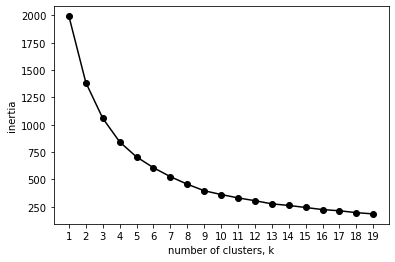

In [9]:
# Using 5 principle components data
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_pcomps.iloc[:,:5])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

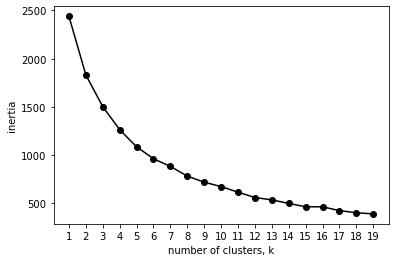

In [10]:
# Using original features (10)
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(features_scaled)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#### Using pca data leads to a significant inertia drop at k=4 compare to orignal 10 features

### c.  KMean modeling

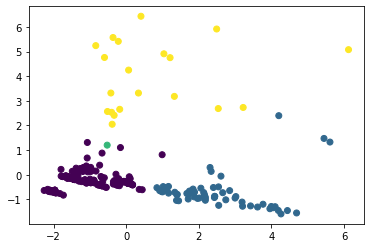

In [11]:
# Create a KMeans object with 4 clusters, use random_state=8 
model = KMeans(n_clusters=4, random_state=8)

# Fit the data to the object
model.fit(df_pcomps.iloc[:,:5])

# Create a scatter plot of the first two principal components
# and color it according to the KMeans cluster assignment 
plt.scatter(df_pcomps[0], df_pcomps[1], c=model.labels_)

In [12]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    df_pcomps,
    labels=labels,
    dimensions=range(5),
    color=model.labels_)
fig.update_traces(diagonal_visible=False)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

#### Explain model results

In [13]:
ft_scaled = pd.DataFrame(features_scaled,index=features.index,columns=features.columns)
ft_scaled.head(2)

,total_victims,age,employeed(Y/N),mental_health_issues,gender,licensed_business_entities,total_gun_deaths,state_population,unemployment_rate,sectors
date,,,,,,,,,,
2009-03-10,0.152239,0.716153,-0.3148,1.595553,0.125029,-3.340382,-2.097089,-0.797100,2.647285,-0.276748
2009-03-29,-0.004607,1.620170,-0.3148,0.363544,0.125029,-3.340382,-2.097089,-0.368481,2.435762,-0.276748


In [14]:
df['cluster'] = model.labels_

In [15]:
ft_scaled['cluster'] = model.labels_

C:\Users\Binhkn\anaconda3\envs\DS\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



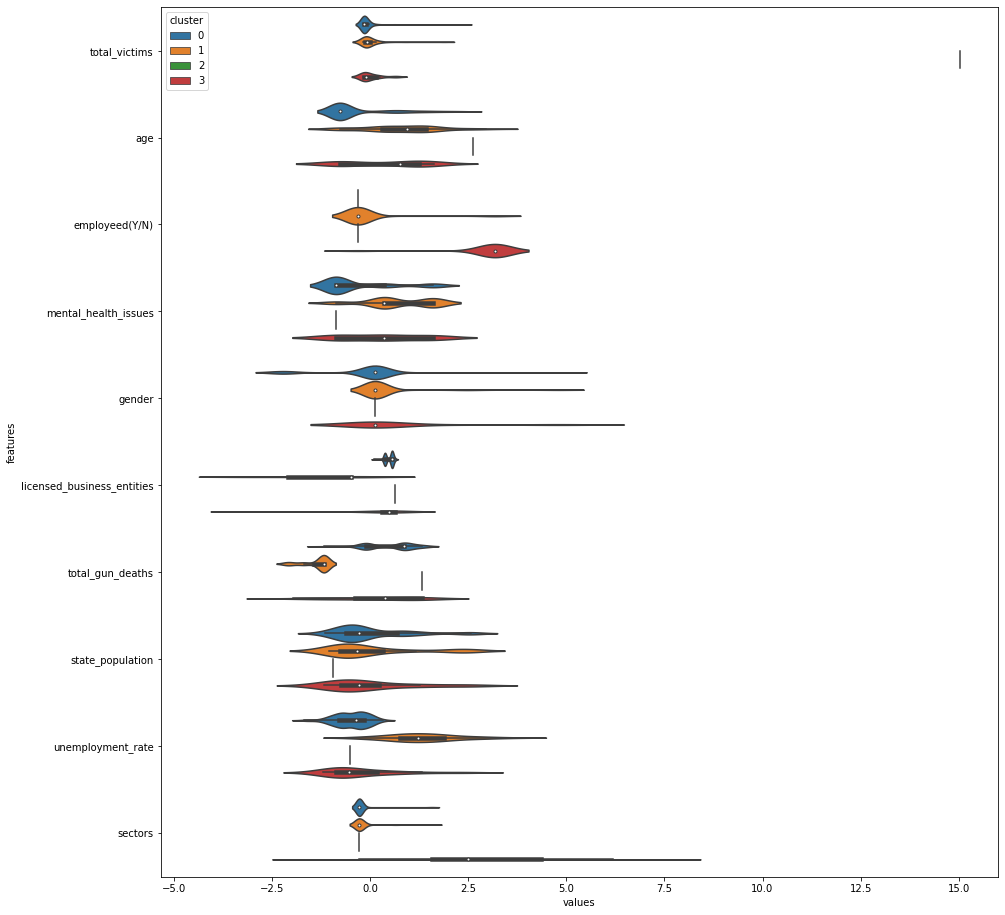

In [16]:
# Reshape the DataFrame to the long format
ft_melt = pd.melt(ft_scaled, id_vars=['cluster'],
    var_name='features', value_name='values',
    value_vars=['total_victims','age','employeed(Y/N)','mental_health_issues','gender','licensed_business_entities',
    'total_gun_deaths','state_population','unemployment_rate','sectors'])

# Create a violin plot splitting and coloring the results according to the km-clusters
plt.figure(figsize=(15,16))
ax = sns.violinplot(ft_melt['values'],ft_melt['features'],hue=ft_melt['cluster'])

,count,mean,sum
cluster,,,
0,160,6.67500,1068
1,63,9.84127,620
2,1,585.00000,585
3,20,10.50000,210


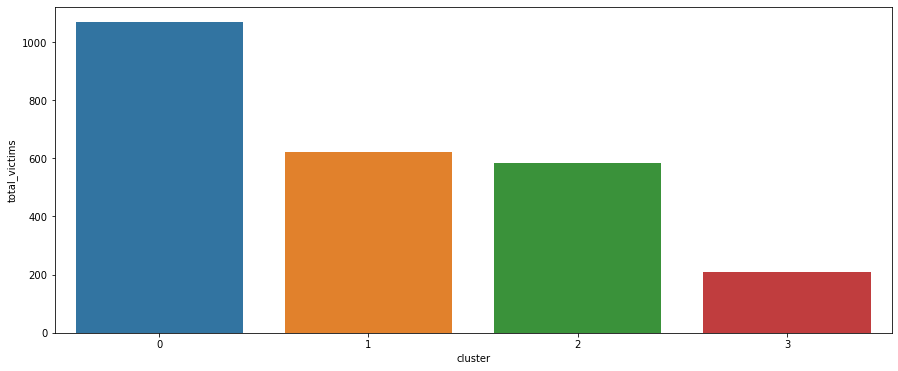

In [17]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='cluster', y='total_victims', data=df, estimator=sum, ci=None)

# Calculate the number of states in each cluster and their 'total_victims' mean and sum.
count_mean_sum = df.groupby('cluster')['total_victims'].agg(['count', 'mean', 'sum'])
count_mean_sum

#### There are 4 clusters have been splitted from the data, let's dive deeper into the result to figure out the logic of this classification

In [18]:
mass_shooting['cluster'] = model.labels_
mass_shooting.index = pd.to_datetime(mass_shooting.index)

List out the states in each cluster

In [20]:
# count number of states labeled by cluster
mass_shooting.groupby(['cluster','state']).size().groupby(level=0).count()

cluster
0    35
1    23
2     1
3    15
dtype: int64

In [45]:
df_gb = mass_shooting.groupby(['cluster','state'])

In [53]:
print(df_gb[np.in1d(df_gb.index.get_level_values(0), [0])].index.get_level_values(1))
# print(df_gb[df_gb.index.isin(['Alabama','California'], level=1)])
# df_gb.loc[(slice(None),['Alabama','California'])]

Index(['Alabama', 'Arizona', 'California', 'Colorado', 'Delaware', 'Florida',
       'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Kansas', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'New Jersey',
       'New Mexico', 'New York', 'North Carolina', 'Ohio', 'Oregon',
       'Pennsylvania', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
       'Virginia', 'Washington', 'Wisconsin'],
      dtype='object', name='state')


In [56]:
cluster_00 = df_gb[np.in1d(df_gb.index.get_level_values(0), [0])].index.get_level_values(1)
cluster_01 = df_gb[np.in1d(df_gb.index.get_level_values(0), [1])].index.get_level_values(1)
cluster_02 = df_gb[np.in1d(df_gb.index.get_level_values(0), [2])].index.get_level_values(1)
cluster_03 = df_gb[np.in1d(df_gb.index.get_level_values(0), [3])].index.get_level_values(1)

In [57]:
print('cluster 3: ',len(cluster_03),np.sort(cluster_03),'\n','cluster 2: ',len(cluster_02),np.sort(cluster_02),
  '\n','cluster 1: ',len(cluster_01),np.sort(cluster_01),'\n','cluster 0: ',len(cluster_00),np.sort(cluster_00))

cluster 3:  15 ['Alabama' 'California' 'Florida' 'Georgia' 'Kansas' 'Kentucky' 'Maryland'
 'Michigan' 'Minnesota' 'Ohio' 'Pennsylvania' 'Texas' 'Virginia'
 'Washington D.C.' 'Wisconsin'] 
 cluster 2:  1 ['Nevada'] 
 cluster 1:  23 ['Alabama' 'Arizona' 'California' 'Colorado' 'Connecticut' 'Florida'
 'Georgia' 'Illinois' 'Louisiana' 'Michigan' 'Minnesota' 'Nevada'
 'New Mexico' 'New York' 'North Carolina' 'Ohio' 'Oklahoma' 'Oregon'
 'Pennsylvania' 'Texas' 'Washington' 'West Virginia' 'Wisconsin'] 
 cluster 0:  35 ['Alabama' 'Arizona' 'California' 'Colorado' 'Delaware' 'Florida'
 'Georgia' 'Idaho' 'Illinois' 'Indiana' 'Kansas' 'Louisiana' 'Maine'
 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi'
 'Missouri' 'Montana' 'Nebraska' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'Ohio' 'Oregon' 'Pennsylvania' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Virginia' 'Washington' 'Wisconsin']


There are states appearing in more than 1 cluster, why is that?  
Cluster 2 contains only Nevada seems reasonably valid

#### Dig deeper to reveal the hidden mechanism of this clustering

In [22]:
mass_shooting.groupby(['cluster','state']).size()

cluster  state          
0        Alabama             5
         Arizona             7
         California         22
         Colorado            3
         Delaware            1
                            ..
3        Pennsylvania        1
         Texas               2
         Virginia            1
         Washington D.C.     1
         Wisconsin           1
Length: 74, dtype: int64

In [23]:
#count number of state appears in clusters: 74 states apprear in 4 clusters (there are duplicates)
#there are 41 states have at least one incident
state_clustered = mass_shooting.groupby(['cluster','state']).size().groupby(level=1).count()
print(type(state_clustered),state_clustered.sum(),len(state_clustered.index))

<class 'pandas.core.series.Series'> 74 41


In [24]:
#count number of states have at least a mass shooting case: 41 states
#there are 244 incidents in total in USA from 2009-2018
state_cases = mass_shooting.groupby('state')['total_victims'].apply(lambda x: (x != 0).sum()).reset_index(name='count')
print(type(state_cases),state_cases['count'].sum(),len(state_cases.index))

<class 'pandas.core.frame.DataFrame'> 244 41


In [25]:
#number of incidents per year
for i in range(2009,2019): 
  print(i,': ',mass_shooting['total_victims'][(mass_shooting.year== i) & (mass_shooting.state=='Texas')].count())

2009 :  1
2010 :  0
2011 :  0
2012 :  0
2013 :  1
2014 :  1
2015 :  4
2016 :  5
2017 :  1
2018 :  1


In [26]:
state_dict = {k: v for k, v in zip(state_cases['state'],state_cases['count'])}

In [27]:
#Number of mass shooting cases by state from 2009-2018
print({k: v for k, v in sorted(state_dict.items(), key=lambda item: item[1],reverse=True)})

{'California': 46, 'Florida': 20, 'New York': 14, 'Texas': 14, 'Georgia': 13, 'Alabama': 11, 'Arizona': 9, 'Washington': 9, 'Pennsylvania': 8, 'North Carolina': 7, 'Ohio': 7, 'Tennessee': 7, 'Virginia': 7, 'Illinois': 6, 'Louisiana': 5, 'Maryland': 5, 'Michigan': 5, 'New Mexico': 5, 'Wisconsin': 5, 'Colorado': 4, 'Missouri': 4, 'Nevada': 4, 'Kansas': 3, 'Minnesota': 3, 'Connecticut': 2, 'Mississippi': 2, 'Nebraska': 2, 'New Jersey': 2, 'Oklahoma': 2, 'Oregon': 2, 'Delaware': 1, 'Idaho': 1, 'Indiana': 1, 'Kentucky': 1, 'Maine': 1, 'Massachusetts': 1, 'Montana': 1, 'South Carolina': 1, 'South Dakota': 1, 'Washington D.C.': 1, 'West Virginia': 1}


It seems that the clustering mechanism doesnt put strong weight on number of cases per state!? Should I create another feature of 'sum cases per state' then run model again?

In [28]:
#Double check number of cases in state
for i in range(2009,2019):
  print(i,': ',mass_shooting['total_victims'][(mass_shooting.year== i) & (mass_shooting.state=='Nevada')].sum())

2009 :  0
2010 :  0
2011 :  12
2012 :  0
2013 :  3
2014 :  3
2015 :  0
2016 :  0
2017 :  585
2018 :  0


A proposed approach is if states appear in cluster 0 will not be presented in the rest & the same for cluster 1, 2, 3?

In [60]:
state_00 = mass_shooting.state[mass_shooting.cluster == 0].unique()
state_01 = mass_shooting.state[mass_shooting.cluster == 1].unique()
state_02 = mass_shooting.state[mass_shooting.cluster == 2].unique()
state_03 = mass_shooting.state[mass_shooting.cluster == 3].unique()

In [61]:
all_state = mass_shooting.state.unique()
state_01 =  [i for i in state_01 if (i not in state_00) & (i not in state_02)]
# state_02 = [i for i in state_02 if (i not in state_00) & (i not in state_01)]
state_03 = [i for i in state_03 if (i not in state_00) & (i not in state_01) & (i not in state_02)]

print(len(all_state), len(state_00),np.sort(state_00),'\n',len(state_01),np.sort(state_01),'\n',
  len(state_02),np.sort(state_02),'\n',len(state_03),np.sort(state_03),)

41 35 ['Alabama' 'Arizona' 'California' 'Colorado' 'Delaware' 'Florida'
 'Georgia' 'Idaho' 'Illinois' 'Indiana' 'Kansas' 'Louisiana' 'Maine'
 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi'
 'Missouri' 'Montana' 'Nebraska' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'Ohio' 'Oregon' 'Pennsylvania' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Virginia' 'Washington' 'Wisconsin'] 
 3 ['Connecticut' 'Oklahoma' 'West Virginia'] 
 1 ['Nevada'] 
 2 ['Kentucky' 'Washington D.C.']


### 4.3. Summary & Conclusion

Questions:  
1. Should target feature-'total_victims' be used for clustering?
2. Is one-hot encoding for 'state' feature useful for this case?
3. States in the clusters appear duplicately, what is the machenism of this clustering approach?
4. How to improve this clustering model? How to plot PCA >3 components data